# xgboost 实战运用

## 基础二分类问题

### 模型

In [23]:
from numpy import loadtxt
from xgboost import XGBClassifier as XGBC
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as a_s

In [24]:
dataset=loadtxt('C:\\Users\\mis\\Desktop\\xgboost\\pima diabetes\\pima-indians-diabetes.data',delimiter=',')

In [25]:
X=dataset[:,0:8]
Y=dataset[:,8]

In [26]:
seed=7
test_size=0.33
X_train,X_test,y_train,y_test=tts(X,Y,test_size=test_size,random_state=seed)

In [27]:
model=XGBC()
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
y_pred=model.predict(X_test)
predictions=[round(value)for value in y_pred]

In [29]:
accuracy=a_s(y_test,predictions)
print("Accuracy:%.2f%%"%(accuracy*100.0))

Accuracy:77.95%


### 输出特征的重要程度

In [30]:
from xgboost import plot_importance
from matplotlib import pyplot as plt

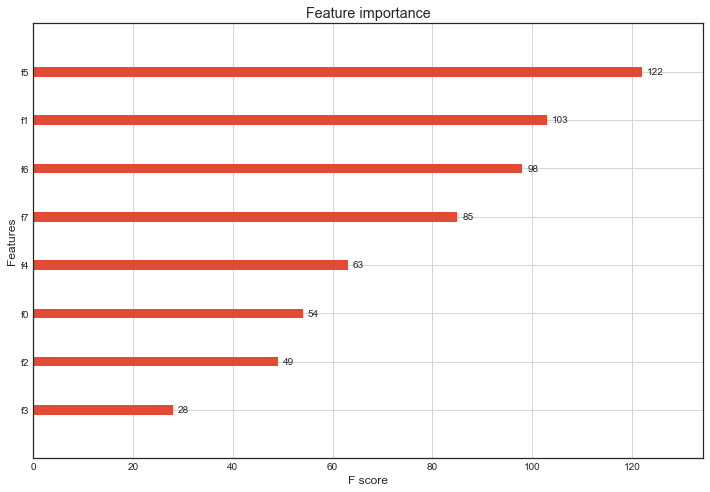

In [31]:
model.fit(X,Y)
plot_importance(model)
plt.show()

### 调参

learning_rate ＝ 0.1 或更小，越小就需要多加入弱学习器；

tree_depth ＝ 2～8；

subsample ＝ 训练集的 30%～80%

可以调的超参数组合有：

树的个数和大小 (n_estimators and max_depth). 

学习率和树的个数 (learning_rate and n_estimators). 

行列的 subsampling rates (subsample, colsample_bytree and colsample_bylevel).

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [33]:
model=XGBC()
learning_rate=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, Y)

In [34]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.483304 using {'learning_rate': 0.1}


In [35]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


-0.689811 (0.000475) with: {'learning_rate': 0.0001}
-0.661827 (0.004625) with: {'learning_rate': 0.001}
-0.531155 (0.028945) with: {'learning_rate': 0.01}
-0.483304 (0.055151) with: {'learning_rate': 0.1}
-0.515642 (0.061723) with: {'learning_rate': 0.2}
-0.554158 (0.067557) with: {'learning_rate': 0.3}


## Titanic分类

### 导入使用的库

In [36]:
import pandas as pd

import matplotlib

import seaborn as sns

import numpy as np

import scipy as sp

import sklearn

import random 

import time

import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


In [37]:
# Models
from sklearn import svm,tree,linear_model,neighbors,naive_bayes,ensemble,discriminant_analysis,gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

### 数据概况

In [38]:
data_train=pd.read_csv("F:\\kaggle\\Titanic\\train.csv")
data_val=pd.read_csv("F:\\kaggle\\Titanic\\test.csv")

In [39]:
data1=data_train.copy(deep=True)

In [40]:
data_cleaner=[data1,data_val]

In [41]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [42]:
data_train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
756,757,0,3,"Carlsson, Mr. August Sigfrid",male,28.0,0,0,350042,7.7958,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
354,355,0,3,"Yousif, Mr. Wazli",male,NaN,0,0,2647,7.2250,NaN,C
156,157,1,3,"Gilnagh, Miss. Katherine ""Katie""",female,16.0,0,0,35851,7.7333,NaN,Q
440,441,1,2,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.0,1,1,F.C.C. 13529,26.2500,NaN,S


### 数据清洗（4C:Correcting, Completing, Creating, and Converting）

数据清洗大致可以分为4个部分，（1）更正（correcting）异常数据；（2）填充（completing）空值和缺失值；（3）创造（creating）新特征进行分析；（4）转换（converting）数据类型方便模型分析。

数据集的异常值并不明显，暂且不管

#### 空值与缺失值 completing

In [43]:
print('Train columns with null values:\n',data1.isnull().sum())
print("--"*10)

print('Validation columns with null values:\n',data_val.isnull().sum())

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [44]:
data_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Karun, Miss. Manca",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [45]:
for dataset in data_cleaner:
    #年龄用中位数填充
    dataset['Age'].fillna(dataset['Age'].median(),inplace=True)
    
    #上船地点用众数填充
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace=True)
    
    #船费用中位数填充
    dataset['Fare'].fillna(dataset['Fare'].median(),inplace=True)

将data_cleaner的数据填充后，对应data1和data_val也填充完毕

In [46]:
# 先将认为不会影响模型的数据列删除
drop_column=['PassengerId','Cabin','Ticket']
data1.drop(drop_column,axis=1,inplace=True)

print(data1.isnull().sum())
print('-'*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


#### 特征工程 creating

In [47]:
for dataset in data_cleaner:
    #创造新特征，家庭成员数量
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1
    
    dataset['IsAlone']=1
    #令家庭成员数=1的人为单独特征
    dataset['IsAlone'].loc[dataset['FamilySize']>1]=0
    #新增特征，头衔
    dataset['Title']=dataset['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0]
    
    #将年龄，船票特征分组
    dataset['FareBin']=pd.qcut(dataset['Fare'],4)
    dataset['AgeBin']=pd.cut(dataset['Age'].astype(int),5)

In [48]:
stat_min = 10
title_names = (data1['Title'].value_counts() < stat_min)
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*10)

 Mr        517
 Miss      182
 Mrs       125
 Master     40
Misc        27
Name: Title, dtype: int64
----------


In [49]:
title_names

 Mr              False
 Miss            False
 Mrs             False
 Master          False
 Dr               True
 Rev              True
 Mlle             True
 Col              True
 Major            True
 Sir              True
 Ms               True
 Don              True
 Lady             True
 Capt             True
 the Countess     True
 Mme              True
 Jonkheer         True
Name: Title, dtype: bool

In [ ]:
data1.info()

#### 数据类型转换

In [ ]:
#object特征转换为分类特征，使用 LabelEncoder。
label =LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code']=label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code']=label.fit_transform(dataset['Embarked'])
    dataset['Title_Code']=label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code']=label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code']=label.fit_transform(dataset['FareBin'])

In [ ]:
Target=['Survived']
#作图用数据
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
#算法用数据
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare']

data1_xy=Target+data1_x

data1_x_bin=['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin=Target+data1_x_bin

data1_dummy=pd.get_dummies(data1[data1_x])
data1_x_dummy=data1_dummy.columns.tolist()
data1_xy_dummy=Target+data1_x_dummy

In [ ]:
data1_dummy.head()

### 数据再检查 Da-Double Check

In [ ]:
print('Train columns with null values:\n',data1.isnull().sum())
print('--'*10)
print(data1.info())
print('--'*10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-"*10)
print (data_val.info())
print("-"*10)

data_train.describe()

### 训练验证集分割

In [ ]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

### 数据初步分析

In [ ]:
for x in data1_x:
    if data1[x].dtype !='float64':
        print('Survival Correlation by:',x)
        print(data1[[x,Target[0]]].groupby(x,as_index=False).mean())
        print('-'*10,'\n')

In [ ]:
print(pd.crosstab(data1['Title'],data1[Target[0]]))

In [ ]:
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'],showmeans=True,meanline=True)
plt.title('Fare Boxplot')
plt.ylabel('Fare($)')

plt.subplot(232)
plt.boxplot(x=data1['Age'],showmeans=True,meanline=True)
plt.title('Age Boxplot')
plt.ylabel('Age(Years)')

plt.subplot(233)
plt.boxplot(x=data1['FamilySize'],showmeans=True,meanline=True)
plt.title('Age Boxplot')
plt.ylabel('Age(Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']],stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

In [ ]:
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

In [ ]:
#graph distribution of qualitative data: Pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = data1, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

In [ ]:
#graph distribution of qualitative data: Sex
#we know sex mattered in survival, now let's compare sex and a 2nd feature
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax  = qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax  = qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survival Comparison')

In [ ]:
#more side-by-side comparisons
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

#how does family size factor with sex & survival compare
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

In [ ]:
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

In [ ]:
a = sns.FacetGrid( data1, hue = 'Survived', aspect=3 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , data1['Age'].max()))
a.add_legend()

In [ ]:
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

In [ ]:
def correlation_heatmap(df):
    _,ax=plt.subplots(figsize=(14,12))
    colormap=sns.diverging_palette(255,15,as_cmap=True)
    
    _=sns.heatmap(
        df.corr(),cmap=colormap,square=True,cbar_kws={'shrink':.95},
        ax=ax,annot=True,linewidths=0.2,vmax=1,linecolor='white',
        annot_kws={'fontsize':12}
        )
    plt.title('Pearson Correlation of Features',y=1.05,size=15)

correlation_heatmap(data1)

### 模型选择

In [ ]:
MLA=[
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

In [ ]:
cv_split=model_selection.ShuffleSplit(n_splits=10,test_size=.3,train_size=.6,random_state=0)
#60%作为训练数据集，30%作为验证集

MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
MLA_predict=data1[Target]

row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #交叉验证
    cv_results=model_selection.cross_validate(alg,data1[data1_x_bin],data1[Target],cv=cv_split)
    MLA_compare.loc[row_index,'MLA Time']=cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()  
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

In [ ]:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

In [ ]:
sns.barplot(x='MLA Test Accuracy Mean',y='MLA Name',data=MLA_compare,color='m')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

### 模型聚合（Majority/Hard Voting/Soft Voting）

In [ ]:
correlation_heatmap(MLA_predict)

In [ ]:
vote_set = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())
]

In [ ]:
vote_hard=ensemble.VotingClassifier(estimators=vote_set,voting='hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

In [ ]:
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))

In [ ]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, data1[data1_x_bin], data1[Target], cv  = cv_split)
grid_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

In [ ]:
print(data_val.info())
print("-"*10)
data_val['Survived'] = grid_hard.predict(data_val[data1_x_bin])

submit = data_val[['PassengerId','Survived']]
submit.to_csv("../kaggle/Titanic/submit.csv", index=False)
print('Validation Data Distribution: \n', data_val['Survived'].value_counts(normalize = True))
submit.sample(10)